In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import modf

In [44]:
# Convert tenor to month
def convert_to_month(tenor):
    if 'y' in tenor.lower():
        return int(tenor.lower().replace('y', '')) * 12
    elif 'm' in tenor.lower():
        return int(tenor.lower().replace('m', ''))
    else:
        return int(tenor)
    
# Convert strike to float
def strike_to_float(strike):
    strike = strike.replace('atm', '0')
    strike = strike.replace('%', '/100')
    return eval(strike)

def calculate_start_date(row):
    # 获取完整年数和额外的月数
    full_years, additional_months = map(int, modf(row['Expiry']))

    # 计算新的年份和月份
    new_year = row['Date'].year + full_years
    new_month = row['Date'].month + additional_months

    # 处理月份超过12的情况
    if new_month > 12:
        new_year += new_month // 12
        new_month = new_month % 12
        if new_month == 0:
            new_month = 12
            new_year -= 1

    # 设置新的年份和月份，日期默认为1
    return pd.Timestamp(year=new_year, month=new_month, day=1)

# Load Data & Pre-processing

## swap_rates
该文件包含掉期利率的时间序列:
1. 日期： 报价日期
2. 开始日期： 掉期开始日期
3. Tenor: 互换年期
4. 掉期利率：市场掉期利率值（百分比）

This file contains timeseries of swap rates, specifically:
1. Date： quote date
2. Start Date: start date of swap
3. Tenor: swap tenor
4. Swap Rate: market swap rate value （in percentage)

For example, the row item
    (1/13/2021, 1/13/2022, 10y, 1.0813328677467247)
indicates that the swap rate for a 10y swap starting from 1/13/2022 quoted on 1/13/2021 is 1.0813328677467247%



In [45]:
swap_rates = pd.read_csv("market-data-swap-rates.csv")
swap_rates = swap_rates.drop_duplicates()
swap_rates

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
1,2021-01-13,2022-01-13,15y,1.265960
2,2021-01-13,2022-01-13,18M,0.221625
3,2021-01-13,2022-01-13,1y,0.195474
4,2021-01-13,2022-01-13,2y,0.279370
...,...,...,...,...
63175,2024-01-12,2039-01-12,2y,3.424505
63176,2024-01-12,2039-01-12,3y,3.393758
63177,2024-01-12,2039-01-12,4y,3.358897
63178,2024-01-12,2039-01-12,5y,3.319531


In [6]:
swap_rates_10y = swap_rates[swap_rates['Tenor'] == '10y']
swap_rates_10y

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
9,2021-01-13,2022-07-13,10y,1.155757
18,2021-01-13,2023-01-13,10y,1.230669
27,2021-01-13,2024-01-15,10y,1.365134
36,2021-01-13,2025-01-13,10y,1.467907
...,...,...,...,...
63135,2024-01-12,2028-01-12,10y,3.323418
63144,2024-01-12,2029-01-12,10y,3.364740
63153,2024-01-12,2032-01-12,10y,3.427397
63162,2024-01-12,2034-01-12,10y,3.403015


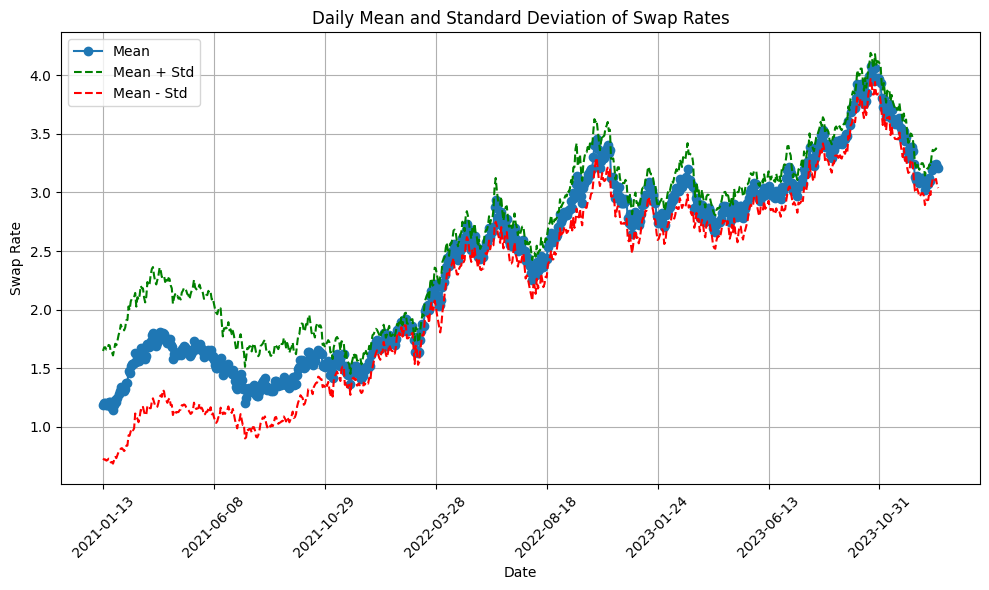

In [29]:
# 计算均值和标准差
mean_std = swap_rates.groupby('Date')['Swap Rate'].agg(['mean', 'std'])

# 绘制均值和标准差
plt.figure(figsize=(10, 6))
mean_std['mean'].plot(label='Mean', marker='o', linestyle='-')
(mean_std['mean'] + mean_std['std']).plot(label='Mean + Std', linestyle='--', color='green')
(mean_std['mean'] - mean_std['std']).plot(label='Mean - Std', linestyle='--', color='red')

plt.title('Daily Mean and Standard Deviation of Swap Rates')
plt.xlabel('Date')
plt.ylabel('Swap Rate')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [40]:
swap_rates[(swap_rates['Date'] == '2021-01-13') & (swap_rates['Tenor'] == '10y')]

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,10y,1.081333
9,2021-01-13,2022-07-13,10y,1.155757
18,2021-01-13,2023-01-13,10y,1.230669
27,2021-01-13,2024-01-15,10y,1.365134
36,2021-01-13,2025-01-13,10y,1.467907
45,2021-01-13,2026-01-13,10y,1.543005
54,2021-01-13,2029-01-15,10y,1.646184
63,2021-01-13,2031-01-13,10y,1.656352
72,2021-01-13,2036-01-14,10y,1.595597


In [7]:
swap_rates['Date'] = pd.to_datetime(swap_rates['Date'])
swap_rates['Start Date'] = pd.to_datetime(swap_rates['Start Date'])
swap_rates.dtypes

Date          datetime64[ns]
Start Date    datetime64[ns]
Tenor                 object
Swap Rate            float64
dtype: object

In [8]:
swap_rates['Tenor'] = swap_rates['Tenor'].apply(convert_to_month)
#swap_rates['Start Date (Month)'] = swap_rates['Start Date'].dt.to_period('M')
swap_rates.head(5)

,Date,Start Date,Tenor,Swap Rate
0,2021-01-13,2022-01-13,120,1.081333
1,2021-01-13,2022-01-13,180,1.265960
2,2021-01-13,2022-01-13,18,0.221625
3,2021-01-13,2022-01-13,12,0.195474
4,2021-01-13,2022-01-13,24,0.279370


In [6]:
swap_rates['End Date'] = swap_rates.apply(lambda x: x['Start Date'] + pd.DateOffset(months=x['Tenor']), axis=1)
swap_rates

,Date,Start Date,Tenor,Swap Rate,Start Date (Month),End Date
0,2021-01-13,2022-01-13,120,1.081333,2022-01,2032-01-13
1,2021-01-13,2022-01-13,180,1.265960,2022-01,2037-01-13
2,2021-01-13,2022-01-13,18,0.221625,2022-01,2023-07-13
3,2021-01-13,2022-01-13,12,0.195474,2022-01,2023-01-13
4,2021-01-13,2022-01-13,24,0.279370,2022-01,2024-01-13
...,...,...,...,...,...,...
63175,2024-01-12,2039-01-12,24,3.424505,2039-01,2041-01-12
63176,2024-01-12,2039-01-12,36,3.393758,2039-01,2042-01-12
63177,2024-01-12,2039-01-12,48,3.358897,2039-01,2043-01-12
63178,2024-01-12,2039-01-12,60,3.319531,2039-01,2044-01-12


In [7]:
swap_rates.describe()

,Date,Start Date,Tenor,Swap Rate,End Date
count,61074,61074,61074.000000,61074.000000,61074
mean,2022-07-17 03:51:05.251989504,2028-01-16 14:15:35.809018624,66.000000,2.426095,2033-07-17 11:18:57.046861056
min,2021-01-13 00:00:00,2022-01-13 00:00:00,12.000000,0.167830,2023-01-13 00:00:00
25%,2021-10-13 00:00:00,2024-08-12 00:00:00,24.000000,1.718394,2028-05-06 00:00:00
50%,2022-07-16 12:00:00,2026-07-20 00:00:00,48.000000,2.591198,2032-09-05 12:00:00
75%,2023-04-25 00:00:00,2031-03-06 00:00:00,96.000000,3.035905,2038-01-28 00:00:00
max,2024-01-12 00:00:00,2039-01-12 00:00:00,180.000000,4.249516,2054-01-12 00:00:00
std,NaN,NaN,52.764056,0.818911,NaN


## rates_vols
该文件包含交换隐含正常体积的时间序列，特别是
1. 日期：报价日期
2. 到期：掉期到期日
3. Tenor （期限）：掉期合约的期限
4. 行权价：与 ATM 值的利率差
5. 波动率：市场隐含正常波动率（百分比）

例如，该行项目
    (1/13/2021，10Y，10Y，ATM-1.0%，0.17055186526449959)，
表示在 1/13/2021 日，10 年后开始的 10y 掉期的隐含正常波动率为 0.17055186526449959%，行权价为 0.99* 掉期利率。


This file contains time series of swap implied normal vols, specifically:
1. Date: quote date
2. Expiry: expiry of the swaption
3. Tenor: tenor of the swap to be entered by the swaption
4. Strike: rate spread to ATM value
5. Vols: market implied normal volatility (in percentage)

For example, the row item
    (1/13/2021, 10y, 10y, atm-1.0%, 0.17055186526449959)
indicates that on 1/13/2021, the implied normal volatility for a 10y swap starting in 10 years with strike being 0.99（ATM-1.0%）*swap rate is 0.17055186526449959%

**Expiry 和 Tenor 分别代表期权即将到期的时间点及随后进入的掉期合约的周期长度。这两个概念的区分及结合使用是处理金融衍生工具尤其是掉期期权时的重要基础。**



In [3]:
rates_vols = pd.read_csv("market-data-swaption-vols.csv")
rates_vols = rates_vols.drop_duplicates()
rates_vols

,Date,Expiry,Tenor,Strike,Vols
0,2021-01-13,10y,10y,atm-1.0%,0.170552
1,2021-01-13,10y,10y,atm-0.5%,0.135412
2,2021-01-13,10y,10y,atm,0.114587
3,2021-01-13,10y,10y,atm+0.5%,0.137742
4,2021-01-13,10y,10y,atm+1.0%,0.169685
...,...,...,...,...,...
315895,2024-01-12,8y,8y,atm-1.0%,0.259523
315896,2024-01-12,8y,8y,atm-0.5%,0.243703
315897,2024-01-12,8y,8y,atm,0.239538
315898,2024-01-12,8y,8y,atm+0.5%,0.262953


In [4]:
rates_vols['Date'] = pd.to_datetime(rates_vols['Date'])
rates_vols['Expiry'] = rates_vols['Expiry'].apply(convert_to_month)
rates_vols['Tenor'] = rates_vols['Tenor'].apply(convert_to_month)
rates_vols['Strike'] = rates_vols['Strike'].apply(strike_to_float)

print(rates_vols.dtypes)

rates_vols.head(5)

Date      datetime64[ns]
Expiry             int64
Tenor              int64
Strike           float64
Vols             float64
dtype: object


,Date,Expiry,Tenor,Strike,Vols
0,2021-01-13,120,120,-0.010,0.170552
1,2021-01-13,120,120,-0.005,0.135412
2,2021-01-13,120,120,0.000,0.114587
3,2021-01-13,120,120,0.005,0.137742
4,2021-01-13,120,120,0.010,0.169685


In [5]:
rates_vols_mean = rates_vols.groupby(['Date','Expiry','Tenor'])['Vols'].mean()
rates_vols_mean

Date        Expiry  Tenor
2021-01-13  12      12       0.082409
                    18       0.082992
                    24       0.092528
                    36       0.094342
                    48       0.094922
                               ...   
2024-01-12  180     48       0.258210
                    60       0.261300
                    96       0.267817
                    120      0.269173
                    180      0.267425
Name: Vols, Length: 61074, dtype: float64

In [6]:
rates_vols_std = rates_vols.groupby(['Date','Expiry','Tenor'])['Vols'].std()
rates_vols_std

Date        Expiry  Tenor
2021-01-13  12      12       0.034865
                    18       0.034506
                    24       0.025764
                    36       0.024449
                    48       0.024023
                               ...   
2024-01-12  180     48       0.016508
                    60       0.016618
                    96       0.016351
                    120      0.016274
                    180      0.016095
Name: Vols, Length: 61074, dtype: float64

In [47]:
# 应用到DataFrame
rates_vols['Start Date (Month)'] = rates_vols.apply(calculate_start_date, axis=1).dt.to_period('M')
rates_vols

,Date,Expiry,Tenor,Strike,Vols,Start Date (Month)
0,2021-01-13,120,120,-0.010,0.170552,2031-01
1,2021-01-13,120,120,-0.005,0.135412,2031-01
2,2021-01-13,120,120,0.000,0.114587,2031-01
3,2021-01-13,120,120,0.005,0.137742,2031-01
4,2021-01-13,120,120,0.010,0.169685,2031-01
...,...,...,...,...,...,...
315895,2024-01-12,96,96,-0.010,0.259523,2032-01
315896,2024-01-12,96,96,-0.005,0.243703,2032-01
315897,2024-01-12,96,96,0.000,0.239538,2032-01
315898,2024-01-12,96,96,0.005,0.262953,2032-01


In [48]:
rates_vols.describe()

,Date,Expiry,Tenor,Strike,Vols
count,305370,305370.00000,305370.00000,305370.000000,305370.000000
mean,2022-07-17 03:51:05.251989760,66.00000,66.00000,0.000000,0.379990
min,2021-01-13 00:00:00,12.00000,12.00000,-0.010000,0.005489
25%,2021-10-13 00:00:00,24.00000,24.00000,-0.005000,0.119808
50%,2022-07-16 12:00:00,48.00000,48.00000,0.000000,0.202445
75%,2023-04-25 00:00:00,96.00000,96.00000,0.005000,0.426505
max,2024-01-12 00:00:00,180.00000,180.00000,0.010000,3.338007
std,NaN,52.76371,52.76371,0.007071,0.432678


Date ----- Expiry Date / Start Date ---- End Date
     Expiry                         Tenor

## trade_info
产品数据：区间累计计息票据的具体信息（包括所挂钩的互换利率、付息频率等）
1. **trade name**: 交易名称，表示每个交易的唯一标识名。
2. **underlying**: 基础利率，通常表示这笔交易所依据的基准利率类型。例如，USD: CMS:2Y 表示这是基于美元的2年期常量期限互换利率 (Constant Maturity Swap)。
3. **pay_frequency**: 付息频率，表示利息支付的频次。例如，6M 表示每六个月支付一次利息，4M 则表示每四个月支付一次。
4. **maturity**: 到期时间，这里的5Y表示这笔交易的到期期限为5年。
5. **lower_bound** 和 **upper_bound**: 这两列分别表示区间累计计息的下限和上限。当基础利率在这两个值之间时，投资者能获得收益；若基础利率超出这个区间，可能不会获得收益，具体取决于票据的具体条款。

This file contains information of the portfolio used in IR Vega calculation. For example, the 1st trade is a 5Y range accrual with 2y CMS rate as the underlying, coupon is paid every 6M with lower bound = 0.0042 and upper bound = 0.0379.

该文件包含 IR Vega 计算中使用的投资组合信息。例如，第 1 笔交易是以 2 年期 CMS 利率为标的的 5 年期区间累积，每 600 万支付一次票息，下限 = 0.0042，上限 = 0.0379。

In [50]:
trade_info = pd.read_csv("trade-information.csv")
trade_info

,trade name,underlying,pay_frequency,maturity,lower_bound,upper_bound
0,dummyTrade1,USD: CMS:2Y,6M,5Y,0.0042,0.0379
1,dummyTrade2,USD: CMS:2Y,4M,5Y,0.0042,0.0379
2,dummyTrade3,USD: CMS:5Y,6M,5Y,0.0044,0.0397
3,dummyTrade4,USD: CMS:5Y,4M,5Y,0.0044,0.0397
4,dummyTrade5,USD: CMS:10Y,4M,5Y,0.0046,0.0417
5,dummyTrade6,USD: CMS:10Y,3M,5Y,0.0046,0.0417
6,dummyTrade7,USD: CMS:2Y,6M,10Y,0.0042,0.0379
7,dummyTrade8,USD: CMS:2Y,4M,10Y,0.0042,0.0379
8,dummyTrade9,USD: CMS:5Y,6M,10Y,0.0044,0.0397
9,dummyTrade10,USD: CMS:5Y,4M,10Y,0.0044,0.0397


In [51]:
trade_info['underlying'] = trade_info['underlying'].apply(lambda x: int(x.split(':')[2][:-1]))
trade_info['pay_frequency'] = trade_info['pay_frequency'].apply(convert_to_month)
trade_info['maturity'] = trade_info['maturity'].apply(convert_to_month)
print(trade_info.dtypes)
trade_info.head(5)

trade name        object
underlying         int64
pay_frequency      int64
maturity           int64
lower_bound      float64
upper_bound      float64
dtype: object


,trade name,underlying,pay_frequency,maturity,lower_bound,upper_bound
0,dummyTrade1,2,6,60,0.0042,0.0379
1,dummyTrade2,2,4,60,0.0042,0.0379
2,dummyTrade3,5,6,60,0.0044,0.0397
3,dummyTrade4,5,4,60,0.0044,0.0397
4,dummyTrade5,10,4,60,0.0046,0.0417


In [52]:
trade_info.describe()

,underlying,pay_frequency,maturity,lower_bound,upper_bound
count,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5.666667,4.500000,90.000000,0.004400,0.039767
std,3.446562,1.167748,31.333978,0.000171,0.001621
min,2.000000,3.000000,60.000000,0.004200,0.037900
25%,2.000000,4.000000,60.000000,0.004200,0.037900
50%,5.000000,4.000000,90.000000,0.004400,0.039700
75%,10.000000,6.000000,120.000000,0.004600,0.041700
max,10.000000,6.000000,120.000000,0.004600,0.041700


## ir_vegas

历史风险值：过去一段时间内，测试产品的Interest Rate Vega值 

1. 价值日期：计算 TV 和 Vega 风险的日期。
2. 商品名称：商品标识
3. 交易货币：交易货币
4. 零利率冲击：平行收益率曲线零利率冲击的冲击值（基点
5. TV：以贸易货币计算的贸易总值 
6. 到期桶：掉期合约的到期日 
7. 到期日：掉期合约的到期日 
8. 有效期桶：掉期合约输入的掉期有效期 
9. Vega：交易现金对市场掉期隐含正常波动率的敏感度

This file contains timeseries of TV and IR Vega of each trade, specifically:
1. Value Date: the date on which we compute the TV and Vega risks
2. Trade Name: trade identity
3. Trade Currency: currency of the trade
4. Zero Rate Shock: shock value in bps of the parallel yield curve zero rate shock
5. TV: total value of the trade in its trade currency
6. Expiry Bucket: expiry of the swaption
7. Expiry Date: expiry date of the swaption
8. Tenor Bucket: tenor of the swap to be entered by the swaption
9. Vega: trade's sensitivity in cash towards market swaption implied Normal volatility

For example, the row item
    (2023-05-23, dummyTrade1, USD, -50, -158091.52, 5y, 2028-05-23, 4y, -32.53)
indicates that:
    Market Condition: USD zero rates moves in parallel by -50 basis points on 2023-05-23
    dummyTrade1’s TV under the Market Condition is -158,091.52 in USD
    dummyTrade1’s sensitivity towards USD 5y swaption (underlying 4y IRS) market implied Normal volatility is -32.53 in USD

In [6]:
ir_vegas = pd.read_csv("trade-price-ir-vegas.csv")
ir_vegas = ir_vegas.drop_duplicates()
ir_vegas

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega
0,2022-09-02,dummyTrade1,USD,-100,-227907.098775,1y,2023-09-04,10y,1.962246
1,2022-09-02,dummyTrade1,USD,-50,-222208.400967,1y,2023-09-04,10y,-3.812341
2,2022-09-02,dummyTrade1,USD,-25,-218960.927995,1y,2023-09-04,10y,4.471006
3,2022-09-02,dummyTrade1,USD,-10,-216872.430106,1y,2023-09-04,10y,4.333398
4,2022-09-02,dummyTrade1,USD,-5,-216146.310328,1y,2023-09-04,10y,5.679687
...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,dummyTrade9,USD,10,-547852.055930,15y,2039-01-12,8y,5.007952
3919100,2024-01-12,dummyTrade9,USD,25,-521228.587618,15y,2039-01-12,8y,5.131505
3919101,2024-01-12,dummyTrade9,USD,50,-464905.982097,15y,2039-01-12,8y,3.348622
3919102,2024-01-12,dummyTrade9,USD,75,-391315.041929,15y,2039-01-12,8y,1.063634


In [7]:
ir_vegas['Value Date'] = pd.to_datetime(ir_vegas['Value Date'])
ir_vegas['Expiry Date'] = pd.to_datetime(ir_vegas['Expiry Date'])
ir_vegas['Expiry Bucket'] = ir_vegas['Expiry Bucket'].apply(convert_to_month)
ir_vegas['Tenor Bucket'] = ir_vegas['Tenor Bucket'].apply(convert_to_month)

print(ir_vegas.dtypes)
ir_vegas.head(5)

Value Date         datetime64[ns]
Trade Name                 object
Trade Currency             object
Zero Rate Shock             int64
TV                        float64
Expiry Bucket               int64
Expiry Date        datetime64[ns]
Tenor Bucket                int64
Vega                      float64
dtype: object


,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega
0,2022-09-02,dummyTrade1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246
1,2022-09-02,dummyTrade1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341
2,2022-09-02,dummyTrade1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006
3,2022-09-02,dummyTrade1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398
4,2022-09-02,dummyTrade1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687


In [8]:
Zero_Rate_Shock_0 = ir_vegas[ir_vegas['Zero Rate Shock'] == 0][['Value Date','Trade Name','TV']]
Zero_Rate_Shock_0 = Zero_Rate_Shock_0.drop_duplicates()
Zero_Rate_Shock_0

,Value Date,Trade Name,TV
5,2022-09-02,dummyTrade1,-215402.656152
17,2022-09-02,dummyTrade10,-616299.369241
29,2022-09-02,dummyTrade11,-608678.010978
41,2022-09-02,dummyTrade12,-609360.662412
53,2022-09-02,dummyTrade2,-215836.787208
...,...,...,...
3907529,2024-01-12,dummyTrade5,-200752.707821
3907541,2024-01-12,dummyTrade6,-200966.214770
3907553,2024-01-12,dummyTrade7,-507396.663276
3907565,2024-01-12,dummyTrade8,-508418.039331


# Data Discovery

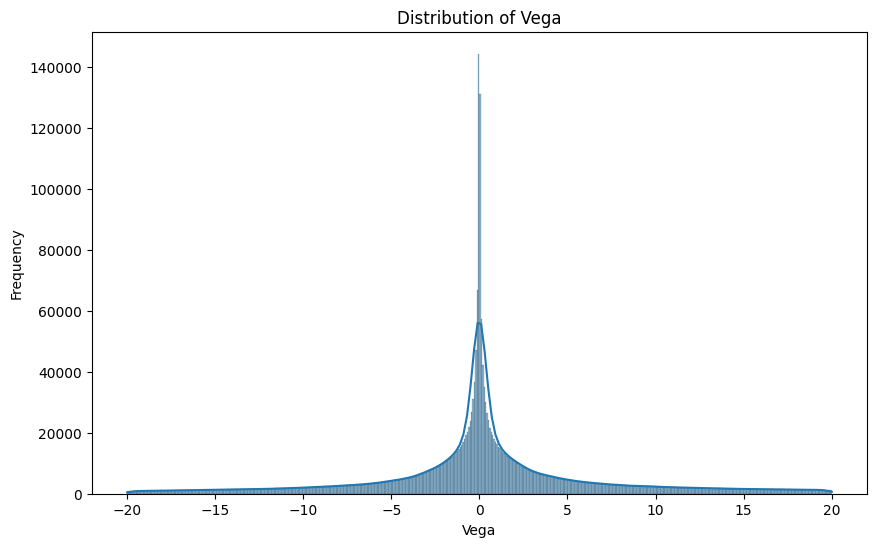

In [17]:
# Plot the distribution of Vega values for the trades
plt.figure(figsize=(10, 6))
sns.histplot(ir_vegas[(abs(ir_vegas['Vega'])<20) & (ir_vegas['Vega']!=0)]['Vega'], kde=True, bins=500)
plt.title('Distribution of Vega')
plt.xlabel('Vega')
plt.ylabel('Frequency')
plt.show()

In [18]:
# 统计每个数值的频率
ir_vegas['Vega'].value_counts().sort_values()

Vega
-2.403380         1
 6.007460         1
 5.278272         1
 2.724804         1
 4.176980         1
              ...  
-0.000007         3
-0.000024         3
-0.000023         3
 0.006767         3
 0.000000    435456
Name: count, Length: 3478503, dtype: int64

# Data merge

In [55]:
# Merge data 市场浮动利率
# 合并 swap_rates 和 rates_vols (根据 Date, Start Date (Month), Tenor 进行合并)
market_rate = pd.merge(rates_vols, swap_rates, on=['Date', 'Start Date (Month)', 'Tenor'])
market_rate

,Date,Expiry,Tenor,Strike,Vols,Start Date (Month),Start Date,Swap Rate,End Date
0,2021-01-13,120,120,-0.010,0.170552,2031-01,2031-01-13,1.656352,2041-01-13
1,2021-01-13,120,120,-0.005,0.135412,2031-01,2031-01-13,1.656352,2041-01-13
2,2021-01-13,120,120,0.000,0.114587,2031-01,2031-01-13,1.656352,2041-01-13
3,2021-01-13,120,120,0.005,0.137742,2031-01,2031-01-13,1.656352,2041-01-13
4,2021-01-13,120,120,0.010,0.169685,2031-01,2031-01-13,1.656352,2041-01-13
...,...,...,...,...,...,...,...,...,...
305365,2024-01-12,96,96,-0.010,0.259523,2032-01,2032-01-12,3.440227,2040-01-12
305366,2024-01-12,96,96,-0.005,0.243703,2032-01,2032-01-12,3.440227,2040-01-12
305367,2024-01-12,96,96,0.000,0.239538,2032-01,2032-01-12,3.440227,2040-01-12
305368,2024-01-12,96,96,0.005,0.262953,2032-01,2032-01-12,3.440227,2040-01-12


In [20]:
# 合并ir_vegas和trade_info
trade_data = pd.merge(ir_vegas, trade_info, left_on='Trade Name', right_on='trade name', how='left')
trade_data.drop(columns='trade name', inplace=True)

In [21]:
trade_data_ = trade_data.astype('category')
trade_data_.to_pickle('trade_data_transfer.pkl')

In [52]:
market_rate = pd.read_pickle('market_rate.pkl')
trade_data = pd.read_pickle('trade_data_transfer.pkl')

# Type transformation
for i in ['Value Date', 'Expiry Date']:
    trade_data[i] = trade_data[i].astype('datetime64[ns]')

for i in ['TV', 'Vega', 'lower_bound', 'upper_bound']:
    trade_data[i] = trade_data[i].astype(float)

for i in ['Zero Rate Shock', 'Expiry Bucket', 'Tenor Bucket', 'underlying', 'pay_frequency', 'maturity']:
    trade_data[i] = trade_data[i].astype(int)

trade_data.dtypes


Value Date         datetime64[ns]
Trade Name               category
Trade Currency           category
Zero Rate Shock             int64
TV                        float64
Expiry Bucket               int64
Expiry Date        datetime64[ns]
Tenor Bucket                int64
Vega                      float64
underlying                  int64
pay_frequency               int64
maturity                    int64
lower_bound               float64
upper_bound               float64
dtype: object

In [10]:
trade_data_merged = pd.merge(
    trade_data,
    swap_rates,
    left_on=['Value Date', 'Expiry Date', 'Tenor Bucket'],
    right_on=['Date', 'Start Date', 'Tenor'],
    how='left'
)
trade_data_merged.drop(columns=['Date', 'Start Date', 'Tenor'], inplace=True)
trade_data_merged

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate
0,2022-09-02,dummyTrade1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,2,6,60,0.0042,0.0379,2.737709
1,2022-09-02,dummyTrade1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,2,6,60,0.0042,0.0379,2.737709
2,2022-09-02,dummyTrade1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,2,6,60,0.0042,0.0379,2.737709
3,2022-09-02,dummyTrade1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,2,6,60,0.0042,0.0379,2.737709
4,2022-09-02,dummyTrade1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,2,6,60,0.0042,0.0379,2.737709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,dummyTrade9,USD,10,-547852.055930,180,2039-01-12,96,5.007952,5,6,120,0.0044,0.0397,3.192330
3919100,2024-01-12,dummyTrade9,USD,25,-521228.587618,180,2039-01-12,96,5.131505,5,6,120,0.0044,0.0397,3.192330
3919101,2024-01-12,dummyTrade9,USD,50,-464905.982097,180,2039-01-12,96,3.348622,5,6,120,0.0044,0.0397,3.192330
3919102,2024-01-12,dummyTrade9,USD,75,-391315.041929,180,2039-01-12,96,1.063634,5,6,120,0.0044,0.0397,3.192330


In [21]:
trade_data_merged.to_pickle('trade_data_merged.pkl')

# 构建模型用数据集

In [33]:
trade_data_merged = pd.read_pickle('trade_data_merged.pkl')
print(trade_data_merged.shape)
trade_data_merged.head()

(3919104, 19)


,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio,check_swap_rate,Vols_mean,Vols_std
0,2022-09-02,1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,24,6,60,0.0042,0.0379,0.027377,0.0,1,0.223827,0.036274
1,2022-09-02,1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,24,6,60,0.0042,0.0379,0.027377,0.0,1,0.223827,0.036274
2,2022-09-02,1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,24,6,60,0.0042,0.0379,0.027377,0.0,1,0.223827,0.036274
3,2022-09-02,1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,24,6,60,0.0042,0.0379,0.027377,0.0,1,0.223827,0.036274
4,2022-09-02,1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,24,6,60,0.0042,0.0379,0.027377,0.0,1,0.223827,0.036274


## Swap rate改为小数

In [8]:
trade_data_merged['Swap Rate'] = trade_data_merged['Swap Rate']/100
trade_data_merged.sample(5)

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate
1846394,2023-05-10,dummyTrade11,USD,-25,-483841.104785,24,2025-05-12,48,0.448072,10,4,120,0.0046,0.0417,0.026001
143543,2022-09-22,dummyTrade7,USD,100,-420526.854972,24,2024-09-23,48,-189.241339,2,6,120,0.0042,0.0379,0.030456
3872824,2024-01-09,dummyTrade5,USD,-5,-202915.264234,12,2025-01-09,18,0.000000,10,4,60,0.0046,0.0417,0.031800
2522378,2023-07-31,dummyTrade4,USD,-25,-179264.617635,24,2025-07-31,18,0.000000,5,4,60,0.0044,0.0397,0.031695
3863285,2024-01-08,dummyTrade2,USD,0,-156049.061562,18,2025-07-08,96,-66.895031,2,4,60,0.0042,0.0379,0.031683


## Trade Name改为int

In [ ]:
trade_data_merged['Trade Name'] = trade_data_merged['Trade Name'].apply(lambda x: x.replace('dummyTrade', '')).astype(int)
trade_data_merged.head()

## underlying改为月为单位

In [10]:
trade_data_merged['underlying'] = trade_data_merged['underlying']*12
trade_data_merged.head()

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate
0,2022-09-02,1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,24,6,60,0.0042,0.0379,0.027377
1,2022-09-02,1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,24,6,60,0.0042,0.0379,0.027377
2,2022-09-02,1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,24,6,60,0.0042,0.0379,0.027377
3,2022-09-02,1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,24,6,60,0.0042,0.0379,0.027377
4,2022-09-02,1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,24,6,60,0.0042,0.0379,0.027377


## 一个产品在某个Zero Rate Shock下的变化率

In [11]:
# 计算TV的变化率
df_TV = trade_data_merged[['Trade Name', 'Zero Rate Shock', 'Value Date', 'TV']].drop_duplicates()
df_TV.sort_values(by=['Trade Name', 'Zero Rate Shock', 'Value Date'], inplace=True)
df_TV['TV Change Ratio'] = df_TV.groupby(['Trade Name', 'Zero Rate Shock'])['TV'].pct_change()
df_TV['TV Change Ratio'].fillna(0, inplace=True) 
df_TV.head()

,Trade Name,Zero Rate Shock,Value Date,TV,TV Change Ratio
0,1,-100,2022-09-02,-227907.098775,0.000000
11664,1,-100,2022-09-06,-226744.270751,-0.005102
23328,1,-100,2022-09-07,-227457.840543,0.003147
34992,1,-100,2022-09-08,-227244.232418,-0.000939
46656,1,-100,2022-09-09,-226754.669563,-0.002154


In [12]:
trade_data_merged = pd.merge(trade_data_merged, df_TV[['Trade Name', 'Zero Rate Shock', 'Value Date', 'TV Change Ratio']], on=['Trade Name', 'Zero Rate Shock', 'Value Date'], how='left')
trade_data_merged.sample(10)

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio
1459625,2023-03-24,12,USD,0,-626939.898281,18,2024-09-24,18,0.000000,120,3,120,0.0046,0.0417,0.026445,0.009129
1911873,2023-05-17,8,USD,50,-447282.377850,180,2038-05-17,180,0.206102,24,4,120,0.0042,0.0379,0.026834,0.000224
1356158,2023-03-13,7,USD,-25,-641284.296092,24,2025-03-13,12,-1.803262,24,6,120,0.0042,0.0379,0.029745,0.009611
2338613,2023-07-07,2,USD,0,-148176.696213,48,2027-07-07,24,102.731654,24,4,60,0.0042,0.0379,0.031703,-0.004989
1837172,2023-05-09,10,USD,25,-494037.179830,48,2027-05-10,36,-3.699061,60,4,120,0.0044,0.0397,0.027949,-0.006176
484192,2022-11-04,3,USD,-5,-202073.557516,48,2026-11-04,36,1.213005,60,6,60,0.0044,0.0397,0.032982,-0.004686
2768565,2023-08-29,10,USD,50,-393877.680515,36,2026-08-28,18,0.000000,60,4,120,0.0044,0.0397,NaN,0.028786
355143,2022-10-20,12,USD,-10,-568263.156678,48,2026-10-20,120,175.859192,120,3,120,0.0046,0.0417,0.033808,-0.013307
1309078,2023-03-07,7,USD,75,-496375.173544,24,2025-03-07,120,44.618991,24,6,120,0.0042,0.0379,0.030378,0.013304
1592447,2023-04-10,5,USD,100,-208147.523324,48,2027-04-12,48,10.134967,120,4,60,0.0046,0.0417,0.026492,-0.001947


## swap rate是否在bound之内

In [13]:
# 判断swap rate是否在【lower_bound, upper_bound】之间
def check_swap_rate(row):
    if row['lower_bound'] <= row['Swap Rate'] <= row['upper_bound']:
        return 1
    return 0

trade_data_merged['check_swap_rate'] = trade_data_merged.apply(check_swap_rate, axis=1)
trade_data_merged.head()

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio,check_swap_rate
0,2022-09-02,1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,24,6,60,0.0042,0.0379,0.027377,0.0,1
1,2022-09-02,1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,24,6,60,0.0042,0.0379,0.027377,0.0,1
2,2022-09-02,1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,24,6,60,0.0042,0.0379,0.027377,0.0,1
3,2022-09-02,1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,24,6,60,0.0042,0.0379,0.027377,0.0,1
4,2022-09-02,1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,24,6,60,0.0042,0.0379,0.027377,0.0,1


In [9]:
trade_data_merged['check_swap_rate'].value_counts()

check_swap_rate
1    3598368
0     320736
Name: count, dtype: int64

## 添加vols的mean和std

In [17]:
trade_data_merged = pd.merge(trade_data_merged, pd.DataFrame(rates_vols_mean), left_on = ['Value Date','Expiry Bucket','Tenor Bucket'], right_on=['Date', 'Expiry', 'Tenor'], how='left')
trade_data_merged.rename(columns={'Vols':'Vols_mean'}, inplace=True)
trade_data_merged

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio,check_swap_rate,Vols_mean
0,2022-09-02,1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827
1,2022-09-02,1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827
2,2022-09-02,1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827
3,2022-09-02,1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827
4,2022-09-02,1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,9,USD,10,-547852.055930,180,2039-01-12,96,5.007952,60,6,120,0.0044,0.0397,0.031923,-0.002294,1,0.267817
3919100,2024-01-12,9,USD,25,-521228.587618,180,2039-01-12,96,5.131505,60,6,120,0.0044,0.0397,0.031923,-0.002554,1,0.267817
3919101,2024-01-12,9,USD,50,-464905.982097,180,2039-01-12,96,3.348622,60,6,120,0.0044,0.0397,0.031923,-0.003037,1,0.267817
3919102,2024-01-12,9,USD,75,-391315.041929,180,2039-01-12,96,1.063634,60,6,120,0.0044,0.0397,0.031923,-0.002968,1,0.267817


In [18]:
trade_data_merged = pd.merge(trade_data_merged, pd.DataFrame(rates_vols_std), left_on = ['Value Date','Expiry Bucket','Tenor Bucket'], right_on=['Date', 'Expiry', 'Tenor'], how='left')
trade_data_merged.rename(columns={'Vols':'Vols_std'}, inplace=True)
trade_data_merged

,Value Date,Trade Name,Trade Currency,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio,check_swap_rate,Vols_mean,Vols_std
0,2022-09-02,1,USD,-100,-227907.098775,12,2023-09-04,120,1.962246,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827,0.036274
1,2022-09-02,1,USD,-50,-222208.400967,12,2023-09-04,120,-3.812341,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827,0.036274
2,2022-09-02,1,USD,-25,-218960.927995,12,2023-09-04,120,4.471006,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827,0.036274
3,2022-09-02,1,USD,-10,-216872.430106,12,2023-09-04,120,4.333398,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827,0.036274
4,2022-09-02,1,USD,-5,-216146.310328,12,2023-09-04,120,5.679687,24,6,60,0.0042,0.0379,0.027377,0.000000,1,0.223827,0.036274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919099,2024-01-12,9,USD,10,-547852.055930,180,2039-01-12,96,5.007952,60,6,120,0.0044,0.0397,0.031923,-0.002294,1,0.267817,0.016351
3919100,2024-01-12,9,USD,25,-521228.587618,180,2039-01-12,96,5.131505,60,6,120,0.0044,0.0397,0.031923,-0.002554,1,0.267817,0.016351
3919101,2024-01-12,9,USD,50,-464905.982097,180,2039-01-12,96,3.348622,60,6,120,0.0044,0.0397,0.031923,-0.003037,1,0.267817,0.016351
3919102,2024-01-12,9,USD,75,-391315.041929,180,2039-01-12,96,1.063634,60,6,120,0.0044,0.0397,0.031923,-0.002968,1,0.267817,0.016351


In [20]:
trade_data_merged['Value Date'].unique()[300:]

<DatetimeArray>
['2023-11-24 00:00:00', '2023-11-27 00:00:00', '2023-11-28 00:00:00',
 '2023-11-29 00:00:00', '2023-11-30 00:00:00', '2023-12-01 00:00:00',
 '2023-12-04 00:00:00', '2023-12-05 00:00:00', '2023-12-06 00:00:00',
 '2023-12-07 00:00:00', '2023-12-08 00:00:00', '2023-12-11 00:00:00',
 '2023-12-12 00:00:00', '2023-12-13 00:00:00', '2023-12-14 00:00:00',
 '2023-12-15 00:00:00', '2023-12-18 00:00:00', '2023-12-19 00:00:00',
 '2023-12-20 00:00:00', '2023-12-21 00:00:00', '2023-12-22 00:00:00',
 '2023-12-25 00:00:00', '2023-12-26 00:00:00', '2023-12-27 00:00:00',
 '2023-12-28 00:00:00', '2023-12-29 00:00:00', '2024-01-01 00:00:00',
 '2024-01-02 00:00:00', '2024-01-03 00:00:00', '2024-01-04 00:00:00',
 '2024-01-05 00:00:00', '2024-01-08 00:00:00', '2024-01-09 00:00:00',
 '2024-01-10 00:00:00', '2024-01-11 00:00:00', '2024-01-12 00:00:00']
Length: 36, dtype: datetime64[ns]

## 处理异常值

In [81]:
# 计算0.01分位数和0.95分位数
quantile_001 = trade_data_merged['Vega'].quantile(0.01)
quantile_095 = trade_data_merged['Vega'].quantile(0.95)

# 对每列单独处理异常值
for col in ['Vega']:
    trade_data_merged.loc[trade_data_merged[col] < quantile_001, col] = quantile_001
    trade_data_merged.loc[trade_data_merged[col] > quantile_095, col] = quantile_095

trade_data_merged.describe()

,Value Date,Trade Name,Zero Rate Shock,TV,Expiry Bucket,Expiry Date,Tenor Bucket,Vega,underlying,pay_frequency,maturity,lower_bound,upper_bound,Swap Rate,TV Change Ratio,check_swap_rate,Vols_mean,Vols_std
count,3919104,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06,3919104,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06,3.738960e+06,3.919104e+06,3.919104e+06,3.919104e+06,3.919104e+06
mean,2023-05-17 21:47:08.571427328,6.500000e+00,6.250000e+00,-3.471395e+05,6.600000e+01,2028-11-16 13:48:34.285713408,6.600000e+01,8.509201e+00,6.800000e+01,4.500000e+00,9.000000e+01,4.400000e-03,3.976667e-02,3.160529e-02,-2.531851e-05,9.181609e-01,6.348165e-01,2.851637e-02
min,2022-09-02 00:00:00,1.000000e+00,-1.000000e+02,-7.174312e+05,1.200000e+01,2023-09-04 00:00:00,1.200000e+01,-1.288287e+02,2.400000e+01,3.000000e+00,6.000000e+01,4.200000e-03,3.790000e-02,2.153075e-02,-4.671975e-01,0.000000e+00,3.110084e-02,1.937373e-03
25%,2023-01-25 18:00:00,3.750000e+00,-1.375000e+01,-5.291890e+05,2.400000e+01,2025-04-22 00:00:00,2.400000e+01,-1.342167e+00,2.400000e+01,4.000000e+00,6.000000e+01,4.200000e-03,3.790000e-02,2.892649e-02,-7.484178e-03,1.000000e+00,2.496088e-01,1.929610e-02
50%,2023-05-23 12:00:00,6.500000e+00,2.500000e+00,-2.242142e+05,4.800000e+01,2027-05-24 00:00:00,4.800000e+01,1.336000e-04,6.000000e+01,4.000000e+00,9.000000e+01,4.400000e-03,3.970000e-02,3.076014e-02,-7.488661e-05,1.000000e+00,4.464985e-01,3.000117e-02
75%,2023-09-18 06:00:00,9.250000e+00,3.125000e+01,-1.857137e+05,9.600000e+01,2031-09-18 06:00:00,9.600000e+01,7.386112e+00,1.200000e+02,6.000000e+00,1.200000e+02,4.600000e-03,4.170000e-02,3.397189e-02,7.269157e-03,1.000000e+00,9.132997e-01,3.623304e-02
max,2024-01-12 00:00:00,1.200000e+01,1.000000e+02,-2.911344e+04,1.800000e+02,2039-01-12 00:00:00,1.800000e+02,1.246439e+02,1.200000e+02,6.000000e+00,1.200000e+02,4.600000e-03,4.170000e-02,4.249516e-02,1.542954e+00,1.000000e+00,3.257591e+00,7.940047e-02
std,NaN,3.452053e+00,5.136167e+01,1.856180e+05,5.276363e+01,NaN,5.276363e+01,3.951451e+01,3.959798e+01,1.118034e+00,3.000000e+01,1.632993e-04,1.552060e-03,3.690525e-03,3.357708e-02,2.741195e-01,5.374183e-01,1.177107e-02


In [82]:
cols = ["Vega", "Trade Name", "Zero Rate Shock", "TV", "Expiry Bucket", "Tenor Bucket", "pay_frequency", "maturity", "Swap Rate", "Vols_std", "TV Change Ratio", "check_swap_rate"]
date_train = trade_data_merged[trade_data_merged['Value Date'] < '2024-01-1']
date_test = trade_data_merged[trade_data_merged['Value Date'] >= '2024-01-1']
date_train = date_train[cols]
date_test = date_test[cols]
date_train.to_pickle('date_train.pkl')
date_test.to_pickle('date_test.pkl')
print('date train: ', date_train.shape)
print('date test: ', date_test.shape)

date train:  (3802464, 12)
date test:  (116640, 12)


In [83]:
cols = ["Vega", "Trade Name", "Zero Rate Shock", "TV", "Expiry Bucket", "Tenor Bucket", "pay_frequency", "maturity", "Swap Rate", "Vols_std", "TV Change Ratio", "check_swap_rate"]
trade_train = trade_data_merged[trade_data_merged['Trade Name'] <= 11]
trade_test = trade_data_merged[trade_data_merged['Trade Name'] > 11]
trade_train = trade_train[cols]
trade_test = trade_test[cols]
trade_train.to_pickle('trade_train.pkl')
trade_test.to_pickle('trade_test.pkl')
print('trade train: ', trade_train.shape)
print('trade test: ', trade_test.shape)

trade train:  (3592512, 12)
trade test:  (326592, 12)
